In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from tslearn.clustering import TimeSeriesKMeans
from jenkspy import jenks_breaks
import random

### Read in Data

In [2]:
df = pd.read_csv('data13to17Feb2018.csv')
df = df[['Time', 'Length']]
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')
df = df[df['Time'] > datetime.datetime(2017,1,1)]

### Select Sample Size

In [3]:
spl_len = 30
spl_val = int(len(df)/spl_len)
splits = [0]
for i in range(spl_len-1):
    splits += [splits[i]+spl_val] 

# Initial Clustering set-up

In [4]:
def put_to_cluster(value, lims):
    cluster_index = 0
    for i in range(1,len(lims)):
        upper = lims[i]
        if value <= upper:
            return cluster_index
        cluster_index += 1
    return len(lims) - 1

In [5]:
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenks_breaks(array, classes)

    # do the actual classification
    classified = np.array([put_to_cluster(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

# StreamSamp set-up

In [6]:
def stream_samp(samps: dict, order: int, L: int):
    if len(samps[order]) > L:
        hi_ord = order+1
        if hi_ord not in samps:
            samps[hi_ord] = []
        samp1 = samps[order].pop(0)
        samp2 = samps[order].pop(0)
        re_samp = random.sample(samp1, int(len(samp1)/2))
        re_samp += random.sample(samp2, int(len(samp2)/2))
        samps[hi_ord].append(re_samp)
        samps = stream_samp(samps, hi_ord, L)
    return samps

# Concise Sampling set-up

In [7]:
def concise_sampling(event):
    N = len(event)
    a = 1.1 # We increase T by 10%
    max_size = N / 10

    # 1/T = selection probability
    T = 1

    #// S = Concise Sample
    S = {}
    S_help = {}
    S_help_real_index = {}
    len_S = 0

    for ev in event:
        
        real_idx, idx, val = ev.split(",")
        
        t_real_idx = int(real_idx)
        try:
            t_idx = datetime.datetime.strptime(idx, '%Y-%m-%d %H:%M:%S.%f')
        except:
            t_idx = datetime.datetime.strptime(idx, '%Y-%m-%d %H:%M:%S')
        
        t_val = float(val)

        if np.random.random() < 1/T:
            if t_val in S:
                S[t_val] += 1
                S_help[t_val].append(t_idx)
                S_help_real_index[t_val].append(t_real_idx)
            else:
                S_help[t_val] = [t_idx]
                S_help_real_index[t_val] = [t_real_idx]
                S[t_val] = 1
            len_S += 1

    
        # Deletion step, Adjust sample when it gets too large
        
        if len_S> max_size:
            T_prime = a * T
            
            for s in S:
                for _ in range(S[s]):
                    if np.random.random() < 1 - T/T_prime:
                        S[s] -= 1
                        len_S -=1
                        if len(S_help[s]) == 1:
                            S_help[s].pop(0)
                            S_help_real_index[s].pop(0)
                        else:
                            rnd_metric = np.random.randint(0,len(S_help[s])-1)
                            S_help[s].pop(rnd_metric)
                            S_help_real_index[s].pop(rnd_metric)
            
            T = T_prime
    
    real_idx_list = []
    idx_list = []
    res_list = []

    for s in S:
        if S[s] > 0:
            for i in range(S[s]):
                idx_list.append(S_help[s][i])
                real_idx_list.append(S_help_real_index[s][i])
                res_list.append(s)

    return idx_list, res_list, real_idx_list

# Cluster Validation

### Rand Index, Fowlkes–Mallows Index, Mirkin Metric, Jaccard Index

In [8]:
def clus_val(df):
    
    res = dict()
    
    df['key1'] = 0
    df['key2'] = 0
    df['index'] = df.index
    cross_joined_df = df.merge(df, left_on='key1', right_on='key2', how='outer')
    cross_joined_df = cross_joined_df[['index_x', 'index_y', 'C_cluster_x', 'C_prime_cluster_x', 'C_cluster_y', 'C_prime_cluster_y']]
    cross_joined_df = cross_joined_df[cross_joined_df['index_x'] != cross_joined_df['index_y']]
    n11 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] == cross_joined_df['C_cluster_y']) \
                      & (cross_joined_df['C_prime_cluster_x'] == cross_joined_df['C_prime_cluster_y'])]) / 2
    n00 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] != cross_joined_df['C_cluster_y']) \
                          & (cross_joined_df['C_prime_cluster_x'] != cross_joined_df['C_prime_cluster_y'])]) / 2

    n10 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] == cross_joined_df['C_cluster_y']) \
                          & (cross_joined_df['C_prime_cluster_x'] != cross_joined_df['C_prime_cluster_y'])]) / 2

    n01 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] != cross_joined_df['C_cluster_y']) \
                          & (cross_joined_df['C_prime_cluster_x'] == cross_joined_df['C_prime_cluster_y'])]) / 2

    n = len(sampled_with_sliced_df)
    
    res['rand_index'] = (2 * (n11 + n00)) / (n * (n - 1))
    res['fm_index'] = n11 / np.sqrt((n11+n10)*(n11+n01))
    res['mirkin_mettric'] = n*(n-1)*(1-res['rand_index'])
    res['jaccard_index'] = n11 / (n11 + n10 + n01)
    
    return res

### F-Measure

In [9]:
def fmeasure(df):
    c = dict()
    c_new = dict()


    for index, row in df.iterrows():
        if row['C_cluster'] not in c:
            c[row['C_cluster']] = 0
        c[row['C_cluster']] = c[row['C_cluster']] + 1
        if row['C_prime_cluster'] not in c_new:
            c_new[row['C_prime_cluster']] = 0
        c_new[row['C_prime_cluster']] = c_new[row['C_prime_cluster']] + 1

    f = []
    for k,v in c.items():
        f += [c[k] * (2 * c[k] * c_new[k])/(c[k] + c_new[k])]
    
    return sum(f)/len(f)

# Tests

In [10]:
clus_val2 = []
fm2 = []
clus_val3 = []
fm3 = []
clus_val4 = []
fm4 = []

In [11]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [12]:
for i in range(len(splits)):
    df_n = df[splits[i]:(splits[i] + 10000)]
    # initial cluster
    gvf = 0.0
    nclasses = 2
    X = df_n['Length'].to_numpy()
    while gvf < 0.9:
        gvf = goodness_of_variance_fit(X, nclasses)
        nclasses += 1

    X = df_n['Length'].to_numpy()

    lims = jenks_breaks(X, nclasses)
    df_n['C_cluster'] = df_n['Length'].apply(lambda x: put_to_cluster(x, lims))
    
    #Reservoir Samp
    res = []
    res_size = len(df_n.index)/10
    stream_weight = 1

    i = 0
    for index, row in df_n.iterrows():
        obj = (row['Time'], row['Length'], row['C_cluster'])
        if i < res_size:
            key = np.random.rand()**(1/stream_weight)
            res += [(key,obj)]
        else:
            res_keys = [k for k,v in res]
            thresh = min(res_keys)
            min_ind = res_keys.index(thresh)
            key = np.random.rand()**(1/stream_weight)
            if key > thresh:
                res[min_ind] = (key,obj)
        i += 1

    res_val = [v for k,v in res]
    df2 = pd.DataFrame(res_val, columns=['Time', 'Length', 'C_cluster'])
    
    gvf = 0.0
    nclasses = 2
    X = df2['Length'].to_numpy()
    while gvf < 0.9:
        gvf = goodness_of_variance_fit(X, nclasses)
        nclasses += 1

    lims = jenks_breaks(X, nclasses)
    df2['C_prime_cluster'] = df2['Length'].apply(lambda x: put_to_cluster(x, lims))
    
    #Stream Samp
    alpha = 0.15
    L = max(int(len(df_n)/50),5)
    T = max(int(len(df_n)/500),5)

    samps = {0:[[]]}

    i = 0
    for index, row in df_n.iterrows():
        obj = (row['Time'], row['Length'], row['C_cluster'])
        if np.random.rand() < alpha:
            samps[0][-1].append(obj)
            if len(samps[0][-1]) > T:
                samps[0].append([])
                samps[0][-1].append(samps[0][-2].pop())
                samps = stream_samp(samps, 0, L)
        i+=1

    samp_list = []

    prob_dist = []

    for k,v in samps.items():
        for i in range(len(samps[k])):
            samp_list += samps[k][i]
            prob_dist += [2**k]*len(samps[k][i])

    prob_dist = [i/sum(prob_dist) for i in prob_dist]

    fin_ind = np.random.choice([i for i in range(len(samp_list))], size=min(int(len(df_n)/10),len(samp_list)), replace=False,p=prob_dist)
    fin_ind = fin_ind.tolist()
    fin_samp = [samp_list[i] for i in fin_ind]
    df3 = pd.DataFrame(fin_samp, columns=['Time', 'Length', 'C_cluster'])

    gvf = 0.0
    nclasses = 2
    X = df3['Length'].to_numpy()
    while gvf < 0.9:
        gvf = goodness_of_variance_fit(X, nclasses)
        nclasses += 1

    lims = jenks_breaks(X, nclasses)
    df3['C_prime_cluster'] = df3['Length'].apply(lambda x: put_to_cluster(x, lims))
    
    #ConciseSampling
    event_list = []
    for index, row in df_n.iterrows():
        event_list.append(str(index) + ',' + str(row['Time']) + ',' + str(row['Length']))
        
    idx_list, res_list, real_idx_list = concise_sampling(event_list)
    sampled_df = pd.DataFrame({'Time':idx_list, 'Length':res_list}, index=real_idx_list)
    sampled_with_sliced_df = sampled_df.merge(df_n, how = 'left', left_index=True, right_index=True)
    sampled_with_sliced_df = sampled_with_sliced_df[['Time_x','Length_x', 'C_cluster']]
    sampled_with_sliced_df.columns = ['Time', 'Length', 'C_cluster']
    gvf = 0.0
    nclasses = 2
    X = sampled_with_sliced_df['Length'].to_numpy()
    while gvf < 0.9:
        gvf = goodness_of_variance_fit(X, nclasses)
        nclasses += 1

    lims = jenks_breaks(X, nclasses)

    sampled_with_sliced_df['C_prime_cluster'] = sampled_with_sliced_df['Length'].apply(lambda x: put_to_cluster(x, lims))
    
    #reservoir
    if df2['C_cluster'].nunique() == df2['C_prime_cluster'].nunique():
        clus_val2 += [clus_val(df2)]
        fm2 += [fmeasure(df2)]
    else:
        clus_val2 += ['Error']
        fm2 += ['Error']

    #streamsamp
    if df3['C_cluster'].nunique() == df3['C_prime_cluster'].nunique():
        clus_val3 += [clus_val(df3)]
        fm3 += [fmeasure(df3)]
    else:
        clus_val3 += ['Error']
        fm3 += ['Error']
    #concise
    if sampled_with_sliced_df['C_cluster'].nunique() == sampled_with_sliced_df['C_prime_cluster'].nunique():
        clus_val4 += [clus_val(sampled_with_sliced_df)]
        fm4 += [fmeasure(sampled_with_sliced_df)]
    else:
        clus_val4 += ['Error']
        fm4 += ['Error']

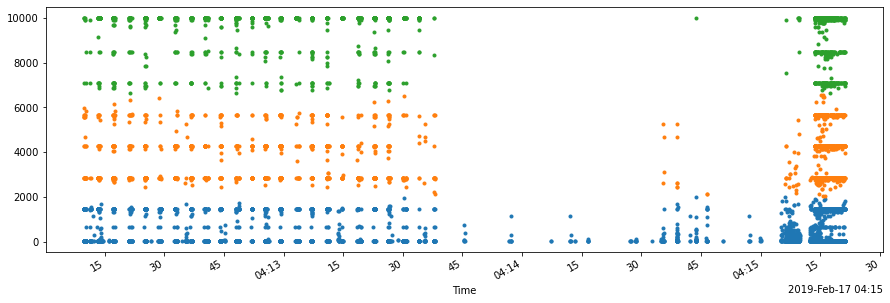

In [13]:
fig, axs = plt.subplots(1, 1, constrained_layout=False, figsize=(15, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

df_n.reset_index().groupby('C_cluster').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)
axs.get_legend().remove()

plt.show()

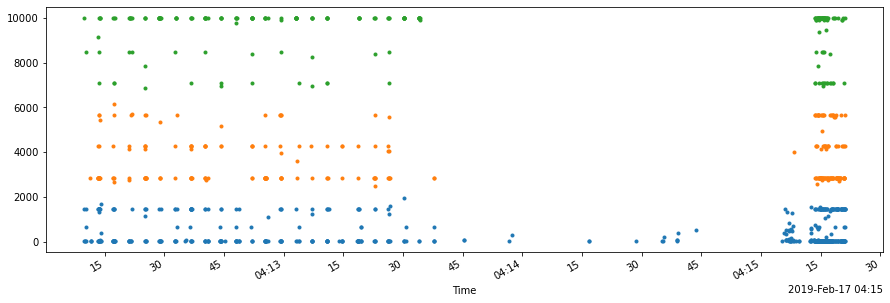

In [14]:
fig, axs = plt.subplots(1, 1, constrained_layout=False, figsize=(15, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

df2.reset_index().groupby('C_cluster').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)
axs.get_legend().remove()

plt.show()

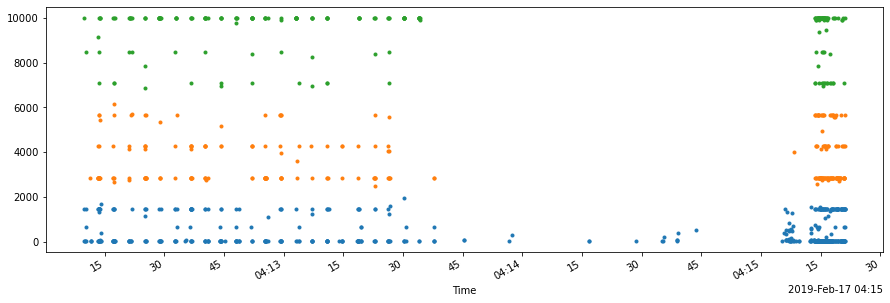

In [15]:
fig, axs = plt.subplots(1, 1, constrained_layout=False, figsize=(15, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

df2.reset_index().groupby('C_prime_cluster').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)
axs.get_legend().remove()

plt.show()

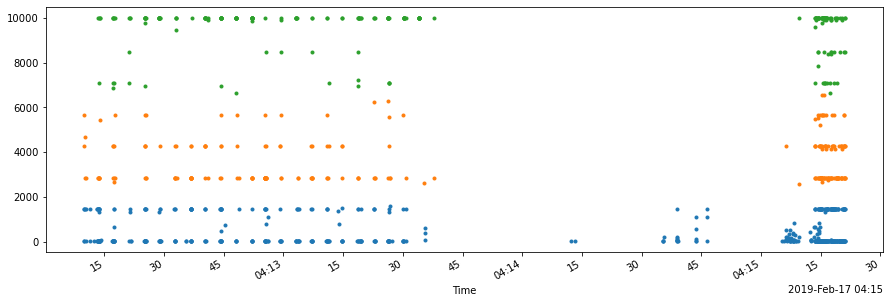

In [16]:
fig, axs = plt.subplots(1, 1, constrained_layout=False, figsize=(15, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

df3.reset_index().groupby('C_cluster').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)
axs.get_legend().remove()

plt.show()

In [17]:
len(sampled_with_sliced_df)

964

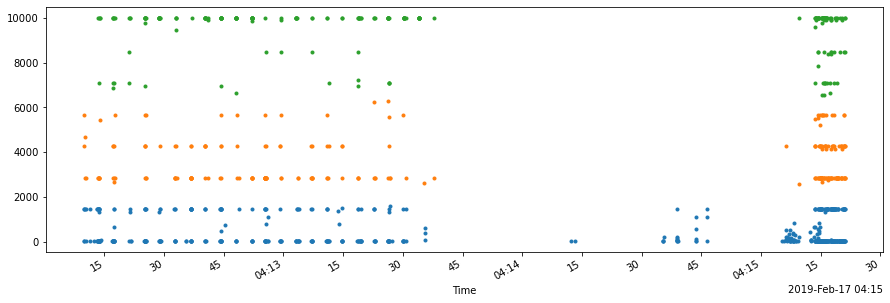

In [18]:
fig, axs = plt.subplots(1, 1, constrained_layout=False, figsize=(15, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

df3.reset_index().groupby('C_prime_cluster').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)
axs.get_legend().remove()

plt.show()

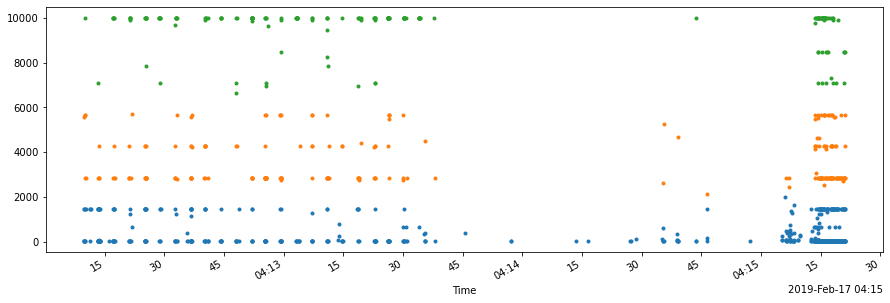

In [19]:
fig, axs = plt.subplots(1, 1, constrained_layout=False, figsize=(15, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

sampled_with_sliced_df.reset_index().groupby('C_cluster').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)
axs.get_legend().remove()

plt.show()

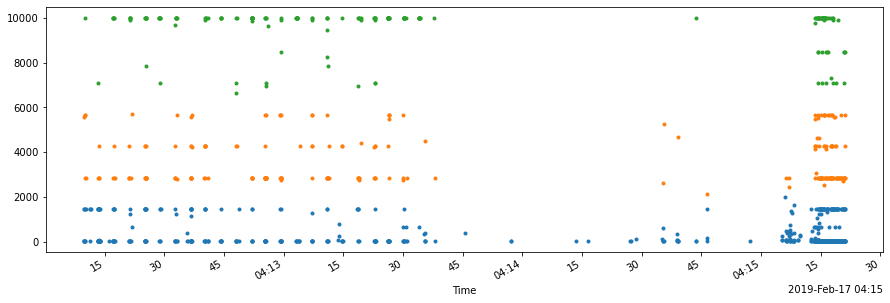

In [20]:
# check the sampled dataset
sampled_with_sliced_df.head()
fig, axs = plt.subplots(1, 1, constrained_layout=False, figsize=(15, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

sampled_with_sliced_df.reset_index().groupby('C_prime_cluster').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)
axs.get_legend().remove()

plt.show()

In [21]:
ri2 = 0
mm2 = 0
jc2 = 0
fm_val2 = 0
fmeas2 = 0
count2 = 0

ri3 = 0
mm3 = 0
jc3 = 0
fm_val3 = 0
fmeas3 = 0
count3 = 0

ri4 = 0
mm4 = 0
jc4 = 0
fm_val4 = 0
fmeas4 = 0
count4 = 0


for i in range(len(clus_val2)):
    if clus_val2[i] != "Error":
        ri2 += clus_val2[i]['rand_index']
        mm2 += clus_val2[i]['mirkin_mettric']
        jc2 += clus_val2[i]['jaccard_index']
        fm_val2 = clus_val2[i]['fm_index']
        count2 += 1
        fmeas2 += fm2[i]
    if clus_val3[i] != "Error":
        ri3 += clus_val3[i]['rand_index']
        mm3 += clus_val3[i]['mirkin_mettric']
        jc3 += clus_val3[i]['jaccard_index']
        fm_val3 = clus_val3[i]['fm_index']
        count3 += 1
        fmeas3 += fm3[i]
    if clus_val4[i] != "Error":
        ri4 += clus_val4[i]['rand_index']
        mm4 += clus_val4[i]['mirkin_mettric']
        jc4 += clus_val4[i]['jaccard_index']
        fm_val4 = clus_val4[i]['fm_index']  
        count4 += 1
        fmeas4 += fm4[i]

In [22]:
print('Avg Rand Index for Reservoir:')
print(ri2/count2)
print('Avg Mirkin Metric for Reservoir:')
print(mm2/count2)
print('Avg Jaccard Index for Reservoir:')
print(jc2/count2)
print('Avg FM Index for Reservoir:')
print(fm_val2/count2)
print('Avg F-Measure for Reservoir:')
print(fmeas2/count2)
print('Error Count for Reservoir:')
print(len(splits) - count2)

Avg Rand Index for Reservoir:
1.1201011865671664
Avg Mirkin Metric for Reservoir:
-103527.0
Avg Jaccard Index for Reservoir:
0.9904444798721439
Avg FM Index for Reservoir:
0.038461538461538464
Avg F-Measure for Reservoir:
188587.97978557047
Error Count for Reservoir:
4


In [25]:
clus_val2

[{'rand_index': 1.1298348174835158,
  'fm_index': 0.9978293706951273,
  'mirkin_mettric': -114600.00000000003,
  'jaccard_index': 0.9956679778917492},
 {'rand_index': 1.163790391914278,
  'fm_index': 1.0,
  'mirkin_mettric': -140598.0000000001,
  'jaccard_index': 1.0},
 {'rand_index': 1.1587821535948926,
  'fm_index': 1.0,
  'mirkin_mettric': -136888.00000000003,
  'jaccard_index': 1.0},
 {'rand_index': 1.0919321624847522,
  'fm_index': 1.0,
  'mirkin_mettric': -84107.99999999993,
  'jaccard_index': 1.0},
 {'rand_index': 1.1786857385639429,
  'fm_index': 0.9998174786263626,
  'mirkin_mettric': -151404.0000000001,
  'jaccard_index': 0.9996350027110306},
 {'rand_index': 1.0077490066024286,
  'fm_index': 0.998651136100191,
  'mirkin_mettric': -7663.999999999968,
  'jaccard_index': 0.9973051491984396},
 {'rand_index': 1.1790114714629656,
  'fm_index': 1.0,
  'mirkin_mettric': -151680.0,
  'jaccard_index': 1.0},
 {'rand_index': 1.1790114714629656,
  'fm_index': 1.0,
  'mirkin_mettric': -151

In [23]:
print('Avg Rand Index for StreamSamp:')
print(ri3/count3)
print('Avg Mirkin Metric for StreamSamp:')
print(mm3/count3)
print('Avg Jaccard Index for StreamSamp:')
print(jc3/count3)
print('Avg FM Index for StreamSamp:')
print(fm_val3/count3)
print('Avg F-Measure for StreamSamp:')
print(fmeas3/count3)
print('Error Count for StreamSamp:')
print(len(splits) - count3)

Avg Rand Index for StreamSamp:
1.1170790591104132
Avg Mirkin Metric for StreamSamp:
-101410.88
Avg Jaccard Index for StreamSamp:
0.9953562892099188
Avg FM Index for StreamSamp:
0.03990863189925118
Avg F-Measure for StreamSamp:
202423.63956184118
Error Count for StreamSamp:
5


In [24]:
print('Avg Rand Index for Concise:')
print(ri4/count4)
print('Avg Mirkin Metric for Concise:')
print(mm4/count4)
print('Avg Jaccard Index for Concise:')
print(jc4/count4)
print('Avg FM Index for Concise:')
print(fm_val4/count4)
print('Avg F-Measure for Concise:')
print(fmeas4/count4)
print('Error Count for Concise:')
print(len(splits) - count4)

Avg Rand Index for Concise:
0.986878176176638
Avg Mirkin Metric for Concise:
11067.250000000007
Avg Jaccard Index for Concise:
0.9796935188832401
Avg FM Index for Concise:
0.041666666666666664
Avg F-Measure for Concise:
175806.83575489558
Error Count for Concise:
6
